# A Steam reviews classifier using Naive Bayes

<div style="text-align: justify">
Steam is a digital platform for the purchase of video games online. It is run by video game developer Valve.

Steam is one of the main options for purchasing video games online and has millions of active users every month.

One of the most important features of Steam is its review system. This system helps the user to decide whether to buy a game or not based on the experiences and recommendations of buyers of the game.

The review system classifies reviews as positive or negative, and cumulative reviews are classified as overhwelmingly positive, very positive, mostly positive, positive, mixed, overhwelmingly negative, very negative, mostly negative and negative.

</div>

This notebook presents step by step how to build a review classifier system using the **Naïve Bayes algorithm**.

# Importing the data
The data to train the model were obtained from the "Steam Reviews" (Sobkowicz A., 2017) dataset available in Kaggle.

In [80]:
import pandas as pd

steam_reviews = pd.read_csv('/kaggle/input/steam-reviews/dataset.csv') 

In [81]:
steam_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


# Exploratory data analysis

Once, we have imported the dataset is time to analyze the features and their content starting from the features names.

In [82]:
list(steam_reviews.columns)

['app_id', 'app_name', 'review_text', 'review_score', 'review_votes']

- app_id: Game ID.
- app_name: Game name.
- review_text: Text of the review.
- review_score: Whether the review recommends the game or not.
- review_votes: Whether the review was recommended by another user or not.

Number of dataset rows

In [83]:
rows = len(steam_reviews.index)
rows

6417106

Possible values of column "review_score".

In [84]:
list(pd.unique(steam_reviews['review_score']))

[1, -1]

We can see the positive reviews are recorded with a value of 1 and negative reviews are recorded with a value of -1.

Let's explore the number of games.

In [85]:
games = pd.unique(steam_reviews['app_name'])
games_count = len(games)
games_count

9364

In [86]:
import numpy as np

np.random.seed(2810)
sample_size = 20000

sample_id = np.random.randint(0, rows, sample_size)

sample_data = steam_reviews.loc[sample_id, ['review_text', 'review_score']]

### Positive reviews number vs Negative reviews number

Let's explore the number of positive and negative reviews in subset.

In [87]:
vc = sample_data['review_score'].value_counts().reset_index(name='count')
vcn = sample_data['review_score'].value_counts(normalize=True).reset_index(name='proportion')

review_score_stats = pd.merge(vc, vcn, on='index')
review_score_stats.rename(columns={'index': 'review_score'}, inplace=True)
review_score_stats

,review_score,count,proportion
0,1,16344,0.8172
1,-1,3656,0.1828


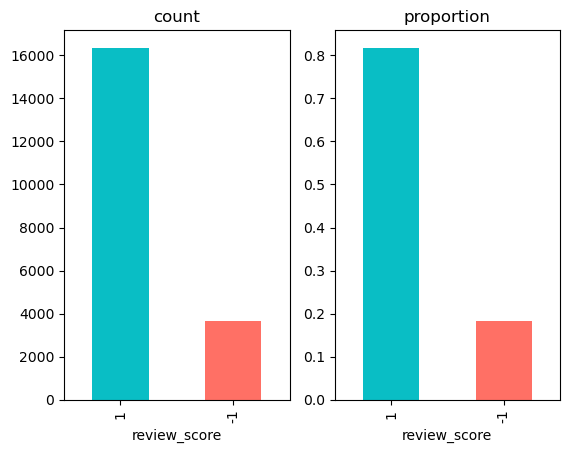

In [88]:
import matplotlib.pyplot as plt

kind = 'bar'
bar_color = ["#09BEC5", "#FF7065"]

fig, axes = plt.subplots(nrows=1,ncols=2)

review_score_stats.plot(x='review_score', 
                        y='count', 
                        ax = axes[0], 
                        kind=kind, 
                        color=bar_color, 
                        subplots=True,
                        legend=False)

review_score_stats.plot(x='review_score', 
                        y='proportion', 
                        ax = axes[1], 
                        kind=kind, 
                        color=bar_color, 
                        subplots=True, 
                        legend=False)

plt.show()

We can see that there are many more positive reviews than negative ones.

### Common reviews

Let's analyze the information for repeated reviews.

In [98]:
# Lowercase review text
reviews_text = sample_data['review_text'].reset_index(name='text')

# Count occurrences of review text
tc = reviews_text['text'].value_counts().reset_index(name='count')
tc.rename(columns={'index': 'text'}, inplace=True)
tc.head(10)

,text,count
0,Early Access Review,3150
1,Early Access Review,32
2,10/10,17
3,.,17
4,Great game,10
5,:),9
6,Great game!,8
7,Great game.,7
8,great game,7
9,Nice game,6


As shown in the table, the text "early access review" is repeated too much, this text does not add information to the model, so it will be removed later.

# Preparing data

<div style="text-align: justify">
Before creating the model and training it, we must preprocess the text of the reviews. This is in order to reduce the amount of data needed to train the model and improve the accuracy of the model.
</div>

### Preprocessing steps
- Lowercase
- Remove punctuation
- Remove stop words
- Stemming
- Tokenize sentences


In [90]:
import sys
sys.path.insert(1, "/kaggle/input/contraction-map")

In [138]:
# Function to remove emojis from text
def remove_emoji(text):
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U0001F1F2"
                        u"\U0001F1F4"
                        u"\U0001F620"
                        u"\u200d"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                        u"\U00002500-\U00002BEF"  # Chinese char
                        u"\U00010000-\U0010ffff"
                        "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

In [91]:
from contractions import CONTRACTION_MAP
import re

"""
Open source code from Sarkar (2018)
Sarkar, D (2018, 3 agosto). 
Text Wrangling & Pre-processing: A Practitioner’s Guide to NLP. KDnuggets. 
Recuperado 6 de marzo de 2023, de https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
"""

# Function to expand english contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [140]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import string

# Function to clean review text
def preprocess_review(review):
    """
    Return a list of strings.
    
    Input
    review: Review text (string)
    -----------------------------------------
    Output
    preprocessed_review: List of tokens from 
    preprocessed review text (list of strings)
    """
    review = review.lower() # Lowecase
    
    # Expand contractions so as not to lose relevant information
    review = expand_contractions(review) 
    
    # Replace happy and sad emoticons by "happy" and "sad" words.
    SAD_FACE = [':(', ':c']
    HAPPY_FACE = [':)', ':D']
    
    for face in SAD_FACE:
        if face in review:
                review = review.replace(face, 'sad')
                
    for face in HAPPY_FACE:
        if face in review:
                review = review.replace(face, 'happy')
        
    # Replace ratings by words
    for match in re.finditer(r'([0-9][0-9]?(\.[0-9])?|100?)\/(100?)', review):
        numerator =  match.group(1)
        denominator = match.group(3)
        rating = float(numerator) / float(denominator)
        
        repl_str = f'{numerator}/{denominator}'
        
        if rating < 0.5:
            review = review.replace(repl_str, 'terrible')
        elif rating < 0.6:
            review = review.replace(repl_str, 'bad')
        elif rating < 0.8:
            review = review.replace(repl_str, 'okay')
        elif rating < 1:
            review = review.replace(repl_str, 'good')
        else:
            review = review.replace(repl_str, 'excellent')
    
    # Remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    review = review.translate(str.maketrans('', '', '0123456789'))
    
    # Remove emojis
    review = remove_emoji(review)
    
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('no')
    all_stopwords.remove('not')

    # Tokenization without stopwords
    review_tokens = word_tokenize(review)
    
    review_tokens = [word for word in review_tokens if not word in all_stopwords]
    
    ps = PorterStemmer()
    
    # Stemming
    preprocessed_review = [ps.stem(word) for word in review_tokens]
        
    return preprocessed_review

In [93]:
# Testing function
np.random.seed(20255)
random_id = np.random.randint(rows)

sample_review = steam_reviews.loc[random_id, "review_text"]
sample_review

"It's not the most flashy, or accompanied with the best music, but it's a game worth playing mostly due to it being an incredibly horrific freakshow and watching the heads pop is an ability worth doing one's best to relive. Play it."

In [141]:
preprocess_review(sample_review)

['not',
 'flashi',
 'accompani',
 'best',
 'music',
 'game',
 'worth',
 'play',
 'mostli',
 'due',
 'incred',
 'horrif',
 'freakshow',
 'watch',
 'head',
 'pop',
 'abil',
 'worth',
 'one',
 'best',
 'reliv',
 'play']

Once the preprocessing function is ready, it is necessary to delete those reviews whose content is "Early Access Review".

In [99]:
sample_data = sample_data[sample_data['review_text'].str.contains('Early Access Review') == False]

In [100]:
# Lowercase review text
reviews_text = sample_data['review_text'].reset_index(name='text')

# Count occurrences of review text
tc = reviews_text['text'].value_counts().reset_index(name='count')
tc.rename(columns={'index': 'text'}, inplace=True)
tc.head(10)

,text,count
0,10/10,17
1,.,17
2,Great game,10
3,:),9
4,Great game!,8
5,great game,7
6,Great game.,7
7,Nice game,6
8,♥♥♥♥,5
9,cool game,4


It can be seen that reviews containing "Early Access Review" have been removed.

### Preparing for training

Before creating the vectors and training the model, we will divide the data into training data and test data.

In [103]:
from sklearn.model_selection import train_test_split

X = sample_data.review_text
y = sample_data.review_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

The training data will contain 80% of the data and the test data will contain 20% of the data.

In [142]:
from sklearn.feature_extraction.text import CountVectorizer

# create a custom analyzer class
class MyAnalyzer(object):
    
    # load spaCy's english model and define the tokenizer/lemmatizer
    def __init__(self):
        pass
        
    # allow the class instance to be called just like
    # just like a function and applies the preprocessing and
    # tokenize the document
    def __call__(self, review):
        return(preprocess_review(review))
    
analyzer = MyAnalyzer()
custom_vec = CountVectorizer(analyzer=analyzer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names_out()

def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

wm2df(cwm, tokens)

,aa,aaa,aaaaaaa,aaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaannnnnnnnnnnnnnnndddddddddddddd,aaaaaaaaaaaand,aaaaand,aaaah,aaaand,...,••gt⌐,…,…but,‾ʖ̫‾,€,€s,ℝℙ,™,≧ω≦,⌐
Doc0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc13437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc13438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc13439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc13440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
wm2df(cwm, tokens).easi

Doc0        0
Doc1        0
Doc2        0
Doc3        0
Doc4        0
           ..
Doc13437    0
Doc13438    0
Doc13439    0
Doc13440    0
Doc13441    0
Name: easi, Length: 13442, dtype: int64